## IMPORTOK

In [53]:
#PYTHON 3.10.11

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline


from imblearn.combine import SMOTEENN # oversampling es undersamplingre

from imblearn.over_sampling import SMOTE

#models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from skopt.searchcv import BayesSearchCV

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.tree import plot_tree

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
# %pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [55]:
df = pd.read_csv("heart.csv")
df.columns = df.columns.str.strip()

df.loc[(df["thall"] == 0) & (df["output"] == 0), "thall"] = 1 # normal

df.loc[(df["thall"] == 0) & (df["output"] == 1), "thall"] = 2 # fixed defect


df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [56]:
df['output'].value_counts()

output
1    165
0    138
Name: count, dtype: int64

Age : Age of the patient 

Sex : Sex of the patient (women=0, men=1)

cp : Chest Pain type chest pain type

- Value 0: typical angina
- Value 1: atypical angina
- Value 2: non-anginal pain
- Value 3: asymptomatic

trtbps : resting blood pressure (in mm Hg)

chol : cholestoral in mg/dl fetched via BMI sensor

fbs : (fasting blood sugar > 120 mg/dl)

- 1 = True
- 0 = False

rest_ecg : resting electrocardiographic results

- Value 0: normal
- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

thalach : maximum heart rate achieved

exng: exercise induced angina

- 1 = True
- 0 = False

old peak: ST depression induced by exercise relative to rest

slp: the slope of the peak exercise ST segment

- 0 = unsloping
- 1 = flat
- 2 = downsloping

caa: number of major vessels (0-3)

thall : thalassemia - vérszegénység

- <sub> 0 = null (dropped it) </sub>
- 1 = fixed defect
- 2 = normal
- 3 = reversable defect

output : 

- 0 = less chance of heart attack
- 1 = more chance of heart attack

In [8]:
df.head()
df['thall'].value_counts()

thall
2    167
3    117
1     19
Name: count, dtype: int64

In [9]:
df.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object

In [10]:
df["oldpeak"].unique().__len__()

40

In [11]:
df['cp'].unique()

filtered_df_1 = df[df['output'] == 1]

cp_counts = filtered_df_1.groupby('cp').size()

print(cp_counts)

cp
0    39
1    41
2    69
3    16
dtype: int64


In [12]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [13]:
df['cp'].unique()

filtered_df_1 = df[df['output'] == 1]

cp_counts = filtered_df_1.groupby('cp').size()

print(cp_counts)

cp
0    39
1    41
2    69
3    16
dtype: int64


In [14]:
filtered_df_0 = df[df['output'] == 0]

cp_counts = filtered_df_0.groupby('cp').size()

print(cp_counts)

cp
0    104
1      9
2     18
3      7
dtype: int64


Mivel az adathalamzunk numerikus adatokat tartalmaz, és nincsenek hiányzó adatok ezért folytathatjuk a vizsgálatot feature selectionnel.<br>
Ha lenne kategorikus adatunk akkor arra az oszlopra LabelEncodert kellene alkalmazni.<br>
Amennyiben hiányzó adatok lennének, úgy lehetne forward/backwardfillel, oszlopátlag alapján számítást végezni. Mivel csak 303 adatunk van, nem érdemes oszlopot törölni.

In [15]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.323432,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.587687,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Adatok eloszlása

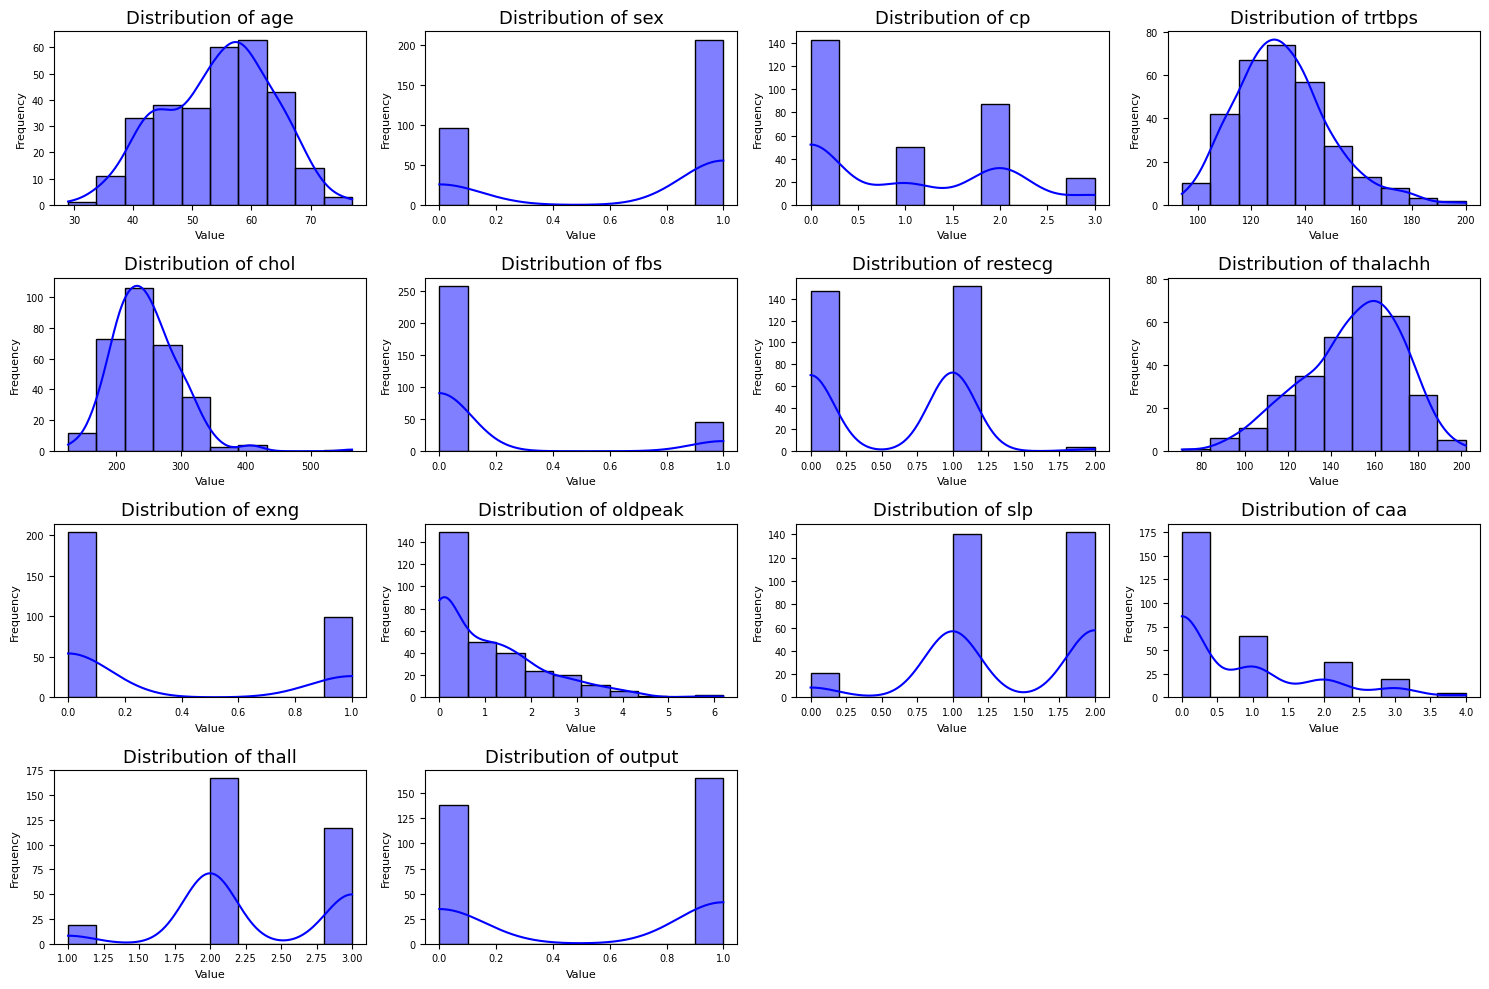

In [16]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[col], kde=True, color="blue", edgecolor="black", bins=10)
    plt.title(f"Distribution of {col}", fontsize=13)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.tick_params(axis='x', labelsize=7)
    plt.tick_params(axis='y', labelsize=7)

plt.tight_layout()
plt.show()

### Férfi és női halálesetek 

C:\Users\Asus\AppData\Local\Temp\ipykernel_12764\300259442.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=['blue', 'red'], ax=axes[1])


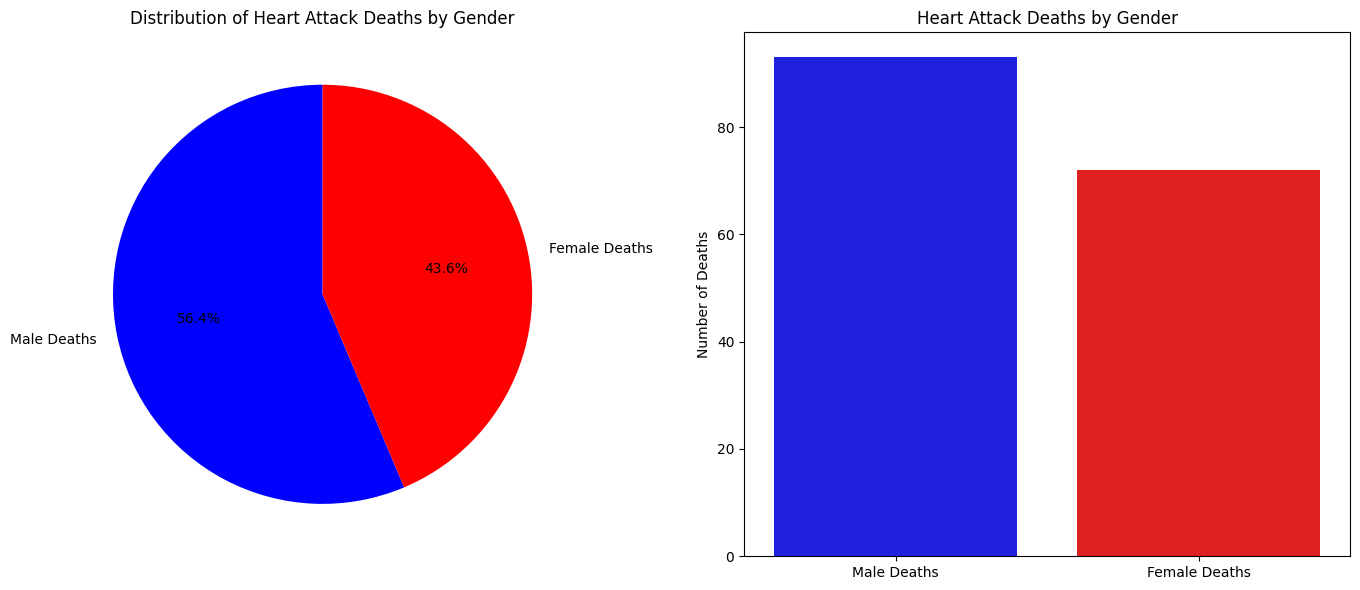

In [17]:

gender_death_counts = df[df['output'] == 1]['sex'].value_counts()

labels = ['Male Deaths', 'Female Deaths']
values = [gender_death_counts.get(1, 0), gender_death_counts.get(0, 0)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
axes[0].set_title("Distribution of Heart Attack Deaths by Gender")

sns.barplot(x=labels, y=values, palette=['blue', 'red'], ax=axes[1])
axes[1].set_ylabel("Number of Deaths")
axes[1].set_title("Heart Attack Deaths by Gender")

plt.tight_layout()
plt.show()



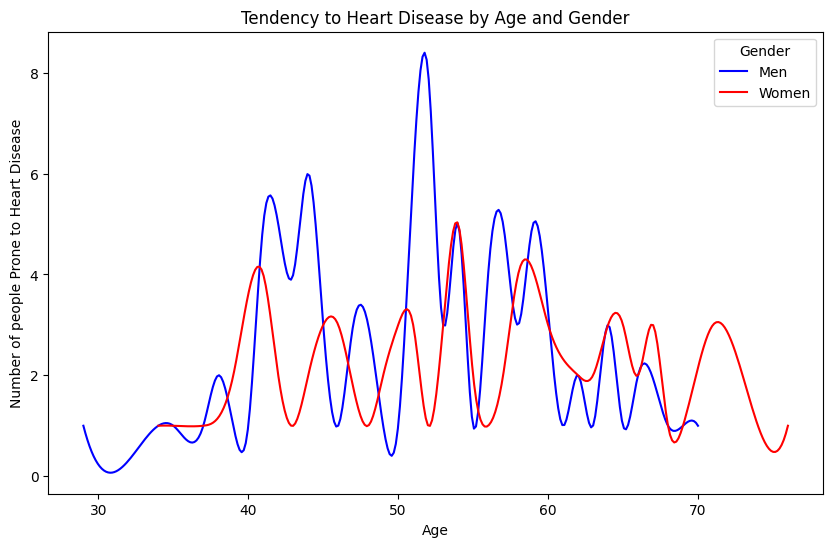

In [53]:
df_deaths = df[df['output'] == 1] # death
df_deaths = df_deaths.groupby(['age', 'sex']).size().reset_index(name='deaths')

x_men = df_deaths[df_deaths['sex'] == 1]['age']
y_men = df_deaths[df_deaths['sex'] == 1]['deaths']
x_women = df_deaths[df_deaths['sex'] == 0]['age']
y_women = df_deaths[df_deaths['sex'] == 0]['deaths']

x_men_smooth = np.linspace(x_men.min(), x_men.max(), 300)
x_women_smooth = np.linspace(x_women.min(), x_women.max(), 300)

y_men_smooth = make_interp_spline(x_men, y_men)(x_men_smooth)
y_women_smooth = make_interp_spline(x_women, y_women)(x_women_smooth)

plt.figure(figsize=(10, 6))
sns.lineplot(x=x_men_smooth, y=y_men_smooth, color='blue', label='Men')
sns.lineplot(x=x_women_smooth, y=y_women_smooth, color='red', label='Women')

plt.title("Tendency to Heart Disease by Age and Gender")
plt.xlabel("Age")
plt.ylabel("Number of people Prone to Heart Disease")
plt.legend(title="Gender")
plt.show()


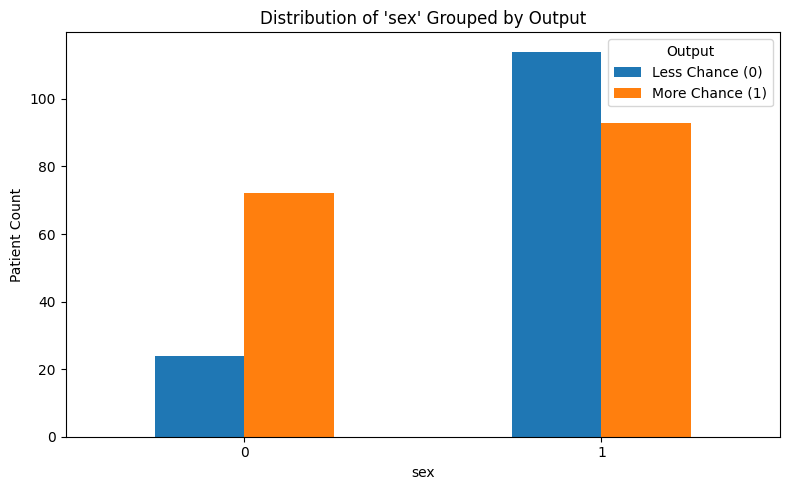

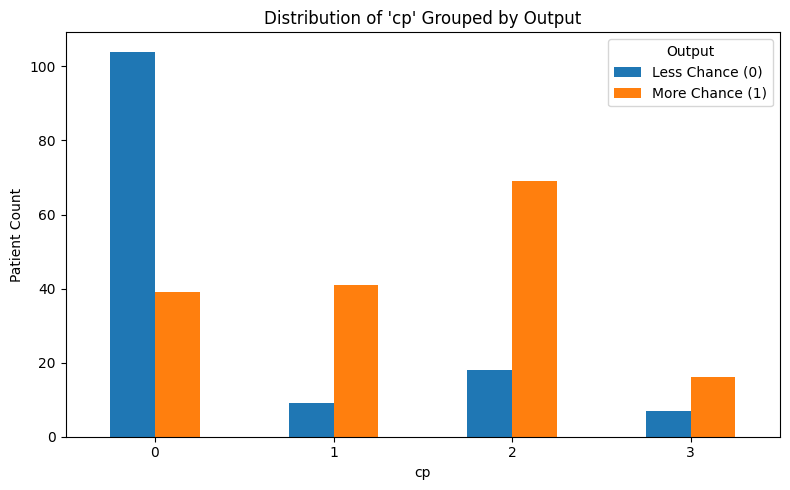

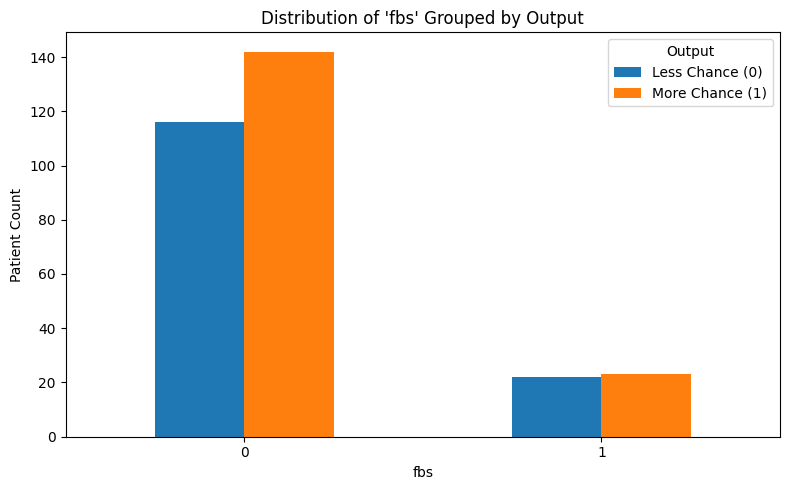

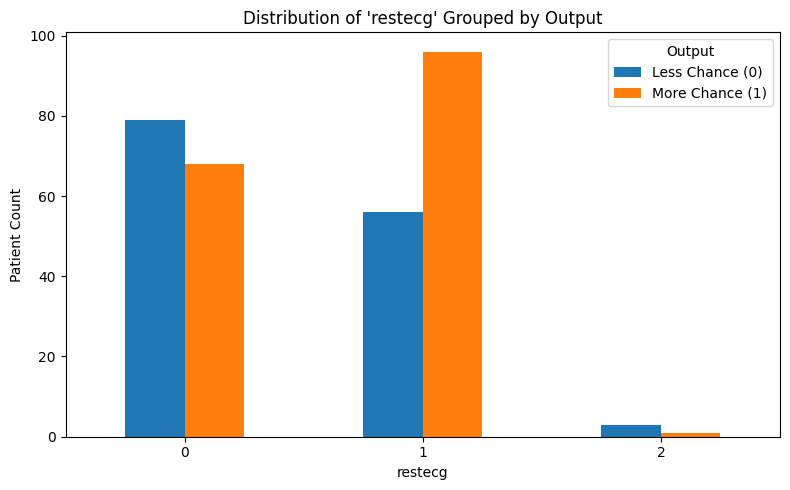

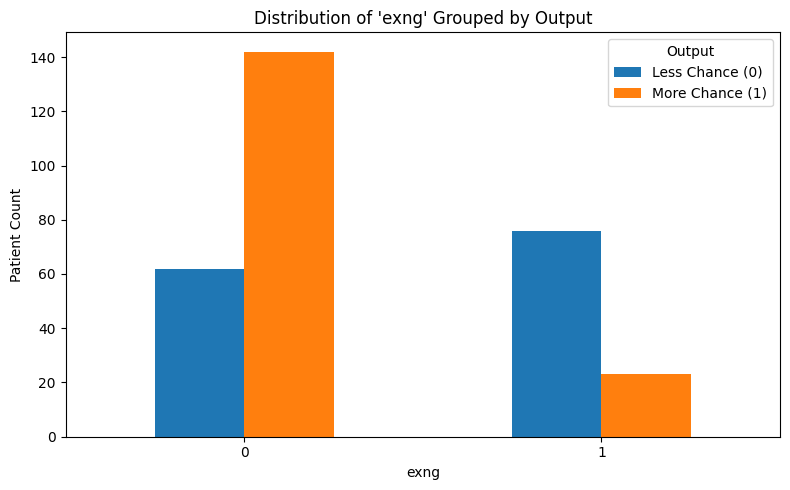

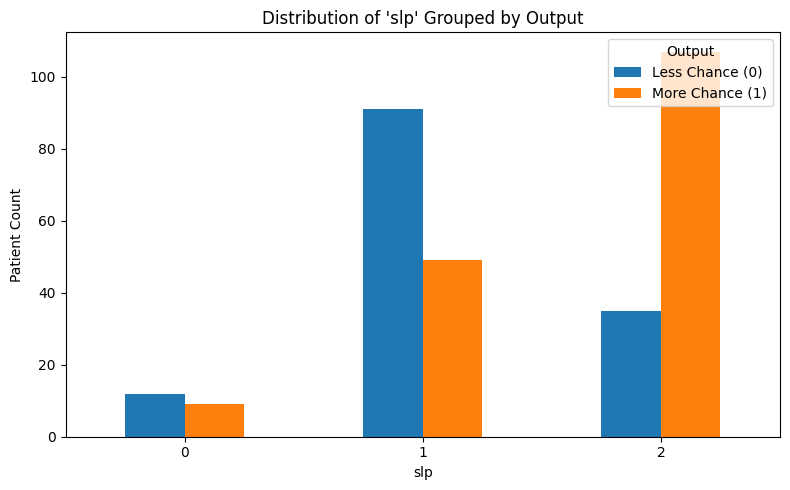

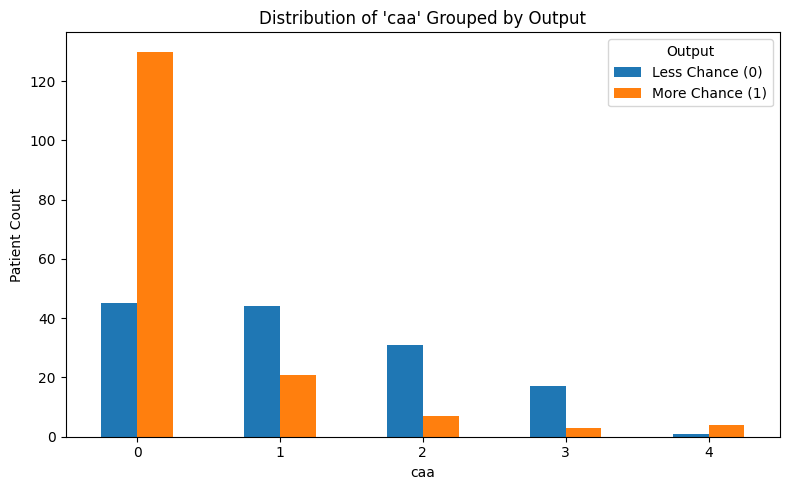

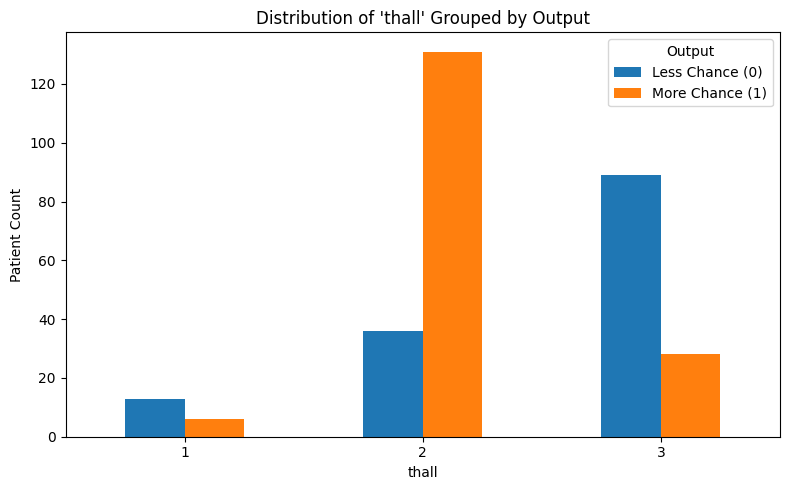

In [18]:
categorical_cols = [col for col in df.columns if df[col].nunique() <= 5 and col != 'output']

for col in categorical_cols:
    grouped_data = df.groupby([col, 'output']).size().unstack(fill_value=0)
    
    grouped_data.plot(kind='bar', stacked=False, figsize=(8, 5))
    
    plt.title(f"Distribution of '{col}' Grouped by Output")
    plt.ylabel("Patient Count")
    plt.xlabel(col)
    plt.xticks(rotation=0)
    plt.legend(title='Output', loc='upper right', labels=['Less Chance (0)', 'More Chance (1)'])
    plt.tight_layout()
    
    # Show the plot
    plt.show()

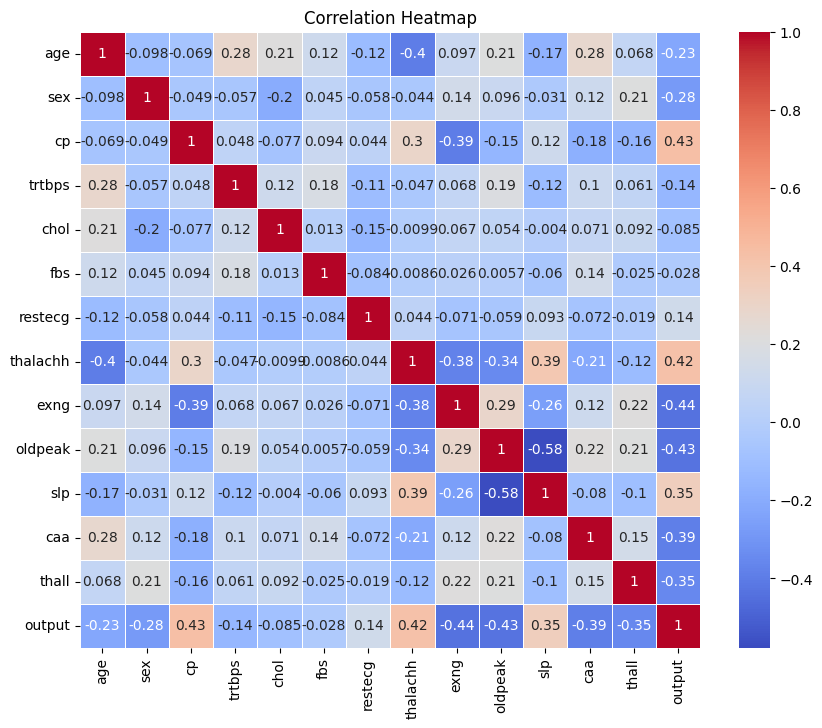

In [19]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5) # 0 semennyi korrelacio, +1 korellal
plt.title('Correlation Heatmap')
plt.show()

In [28]:
print(df["output"].value_counts())

output
1    165
0    138
Name: count, dtype: int64


In [84]:
features_to_keep = ['cp', 'trtbps', 'exng', 'slp', 'caa', 'thall']
X_proba = df.drop("output", axis=1)
y_proba = df["output"]

X_proba_train, X_proba_test, y_proba_train, y_proba_test = train_test_split(X_proba, y_proba, test_size=0.2, stratify=y_proba)
scaler = StandardScaler()
X_proba_train_scaled = X_proba_train
rf = RandomForestClassifier()
model = rf.fit(X_proba_train, y_proba_train)

y_proba_pred = model.predict(X_proba_test)
print(accuracy_score(y_proba_test, y_proba_pred))


0.8524590163934426


0.8524590163934426


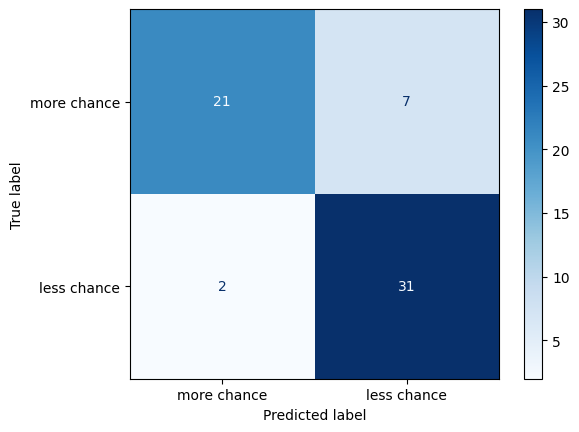

              precision    recall  f1-score   support

           0     0.9130    0.7500    0.8235        28
           1     0.8158    0.9394    0.8732        33

    accuracy                         0.8525        61
   macro avg     0.8644    0.8447    0.8484        61
weighted avg     0.8604    0.8525    0.8504        61



In [85]:
from sklearn.metrics import ConfusionMatrixDisplay

print(accuracy_score(y_proba_test, y_proba_pred))
cm = confusion_matrix(y_proba_test, y_proba_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["more chance", "less chance"])
disp.plot(cmap='Blues')
plt.show()
print(classification_report(y_proba_test, y_proba_pred, digits=4))

chol, fbs, restecg oszlopoknak alacsony a korrelációja a többi magyarázó változóhoz képest, ezért a tanításba nem vesszük be őket, annak reményében, hogy kevesebb zajt viszünk bele a tanulásba, ezáltal jobb eredményt ér el a modell.

In [32]:
X = df.drop("output", axis=1)

X_save = X

X = df.drop(columns=["output", "chol", "fbs", "restecg"])

y = df["output"]

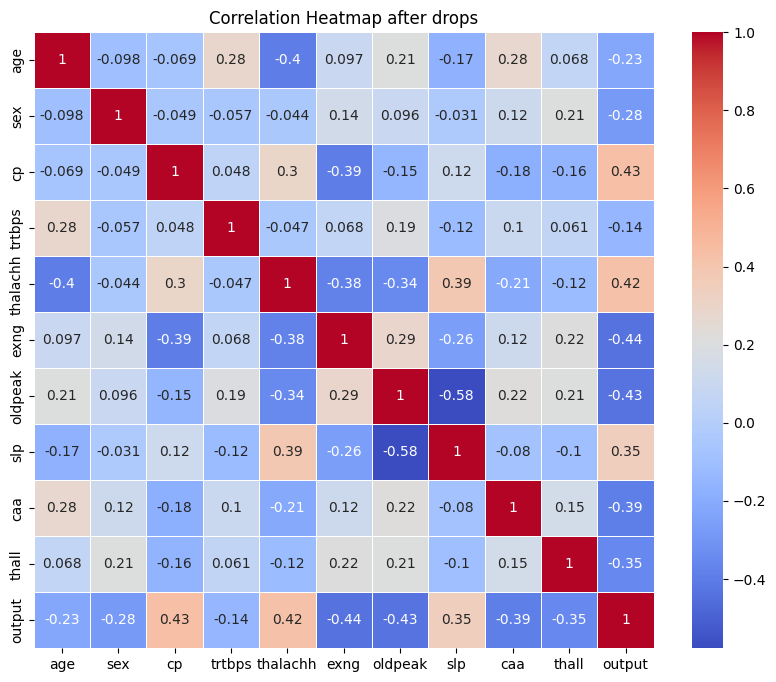

In [33]:
modified_df = X.join(y)
corr_matrix = modified_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5) # 0 semennyi korrelacio, +1 pozitiv korrelacio, -1 negativ korrelacio
plt.title('Correlation Heatmap after drops')
plt.show()

In [43]:
# smoteenn =        ()
# X_resampled, y_resampled =  smoteenn.fit_resample(X, y)

smote = SMOTE(random_state=32, sampling_strategy=0.91)  # 0 - 138,  1 - 165 -> 138 / 165 = 0.8362
X_resampled, y_resampled = smote.fit_resample(X, y)

In [44]:
print("Class distribution after resampling:")
print(np.bincount(y_resampled))
print("X_train count after resampling:\n", len(X_resampled))

Class distribution after resampling:
[150 165]
X_train count after resampling:
 315


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=32, stratify=y_resampled)

In [46]:
print("X_train:", len(X_train))
print("X_test:", len(X_test))

X_train: 252
X_test: 63


In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("y train sizes")
print(f"0: {list(y_train).count(0)} 1: {list(y_train).count(1)}")

print("y test sizes")
print(f"0: {list(y_test).count(0)} 1: {list(y_test).count(1)}")

y train sizes
0: 120 1: 132
y test sizes
0: 30 1: 33


In [48]:
X_train = X_train_scaled
X_test = X_test_scaled
print(f"X_train:{len(X_train)}\nX_test:{len(X_test)}")

X_train:252
X_test:63


In [52]:
from xgboost import XGBClassifier


models_params_gridsearch = {
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9, 11]
        }
    },
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 5, 10, 15, 20]
        }
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [10, 50, 100, 200],
            "max_depth": [None, 5, 10, 15, 20]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='logloss', random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.7, 0.8, 1.0]
        }
    },
    "SVC": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1, 1, 10, 100],
            "gamma": ["scale", "auto"],
            "kernel": ["linear", "rbf"]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {
            "C": [0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs', 'newton-cg'],
            'penalty': ['l2', 'elasticnet'],
            'l1_ratio': [0.5, 0.7, 0.9]
        }
    }
}

In [ ]:
# Grid search
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold


best_model = None
best_params = None
best_score = 0

best_conf_mx = None
best_roc_auc = None
best_class_report = None
best_opt_threshold = None
best_recall = None

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, mp in models_params_gridsearch.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=stratified_kfold, scoring='roc_auc', return_train_score=False, n_jobs=-1) #scoring='roc_auc'
    clf.fit(X_train, y_train)
    
    model = clf.best_estimator_
    model.fit(X_train, y_train)

    

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    conf_mx = confusion_matrix(y_test, y_pred, labels=[0, 1]) # 0=lower,1=higher
    class_report = classification_report(y_test, y_pred, target_names=['lower chance of heart disease', 'higher chance of heart disease'], digits=5)
    
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    
    # fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    # roc_auc = auc(fpr, tpr)

    # optimal_idx = np.argmax(tpr - fpr)
    # opt_threshold = thresholds[optimal_idx]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    opt_threshold = thresholds[np.argmax(tpr - fpr)]

    # Evaluate model performance
    avg_score = (roc_auc + recall) / 2  # Average ROC AUC and Recall


    print("Model Name:", model_name)
    print("Model Best Params:", clf.best_params_)
    print("Accuracy:", accuracy)
    print("(roc_auc+recall)/2:", clf.best_score_)
    print("Confusion Matrix:\n", conf_mx)
    print(class_report)
    print('ROC AUC:', roc_auc)
    print("Optimal Threshold:", opt_threshold)
    print("--------------------------------------")
    
    if avg_score > best_score:
        best_score = avg_score
        best_accuracy = accuracy
        best_model = model_name
        best_params = clf.best_params_
        best_conf_mx = conf_mx
        best_class_report = class_report
        best_roc_auc = roc_auc
        best_opt_threshold = opt_threshold

        disp = ConfusionMatrixDisplay(confusion_matrix=best_conf_mx, display_labels=["more chance", "less chance"])
        disp.plot(cmap='Blues')
        plt.savefig(f"{best_model}.jpg")

        

print("Best Model:", best_model)
print("Best Accuracy:", best_accuracy)
print("Best (roc_auc+recall)/2:", best_score)
print("Best Parameters:", best_params)
print("Confusion Matrix:\n", best_conf_mx)
print(best_class_report)
print('ROC AUC:', best_roc_auc)
print("Optimal Threshold:", best_opt_threshold)

Model Name: KNeighborsClassifier
Model Best Params: {'n_neighbors': 7}
Accuracy: 0.8888888888888888
(roc_auc+recall)/2: 0.8860398860398859
Confusion Matrix:
 [[26  4]
 [ 3 30]]
                                precision    recall  f1-score   support

 lower chance of heart disease    0.89655   0.86667   0.88136        30
higher chance of heart disease    0.88235   0.90909   0.89552        33

                      accuracy                        0.88889        63
                     macro avg    0.88945   0.88788   0.88844        63
                  weighted avg    0.88911   0.88889   0.88878        63

ROC AUC: 0.901010101010101
Optimal Threshold: 0.5714285714285714
--------------------------------------
Model Name: RandomForestClassifier
Model Best Params: {'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.8571428571428571
(roc_auc+recall)/2: 0.8872507122507123
Confusion Matrix:
 [[25  5]
 [ 4 29]]
                                precision    recall  f1-score   support

 lower chance

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packa

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5271 - auc: 0.5000 - loss: 0.7536 - val_accuracy: 0.5714 - val_auc: 0.5000 - val_loss: 0.7799
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5581 - auc: 0.5000 - loss: 0.7382 - val_accuracy: 0.5714 - val_auc: 0.5000 - val_loss: 0.7197
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5279 - auc: 0.5000 - loss: 0.6371 - val_accuracy: 0.5714 - val_auc: 0.5000 - val_loss: 0.6662
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5333 - auc: 0.5000 - loss: 0.6002 - val_accuracy: 0.5714 - val_auc: 0.5000 - val_loss: 0.6262
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5971 - auc: 0.5000 - loss: 0.5812 - val_accuracy: 0.5714 - val_auc: 0.5000 - val_loss: 0.5857
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5271 - auc: 0.5000 - loss: 0.5531 - val_accuracy: 0.5714 - val_auc: 0.5000 - val_loss: 0.5591
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 

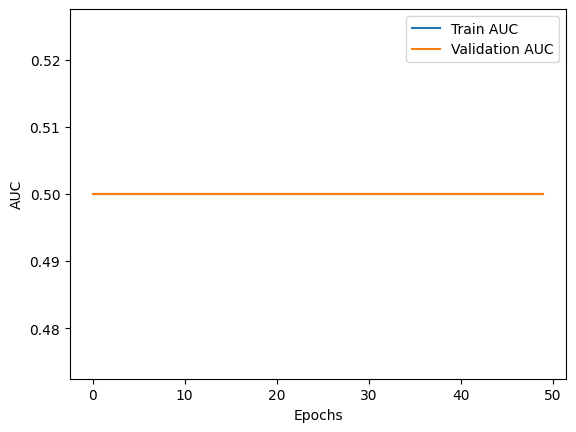

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # prev X, y

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()

model.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=BinaryCrossentropy(), 
              metrics=['accuracy', AUC()])

history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)

loss, accuracy, auc_value = model.evaluate(X_test, y_test)
print(history.history.keys())
print(f'Test AUC: {auc}')
print(f'Test Accuracy: {accuracy}')


max_auc = list(history.history.keys())[-2]
max_val_auc = list(history.history.keys())[1]

plt.plot(history.history[max_auc], label='Train AUC')
plt.plot(history.history[max_val_auc], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [27]:
print(history.history.keys())

dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss'])


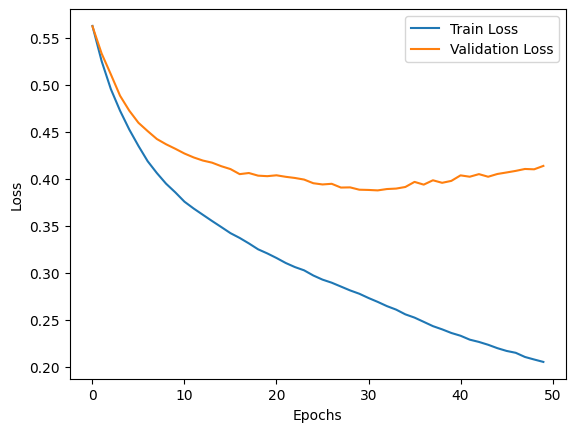

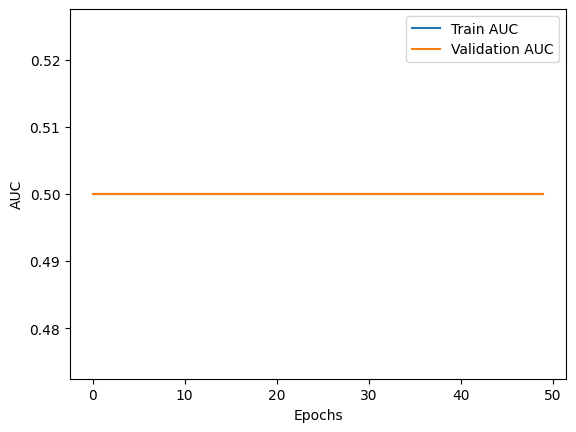

In [28]:
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the AUC
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Confusion Matrix:
 [[ 0 29]
 [ 0 32]]
Classification Report:
                  precision    recall  f1-score   support

No Heart Attack       0.00      0.00      0.00        29
   Heart Attack       0.52      1.00      0.69        32

       accuracy                           0.52        61
      macro avg       0.26      0.50      0.34        61
   weighted avg       0.28      0.52      0.36        61

ROC AUC: 0.5


C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.

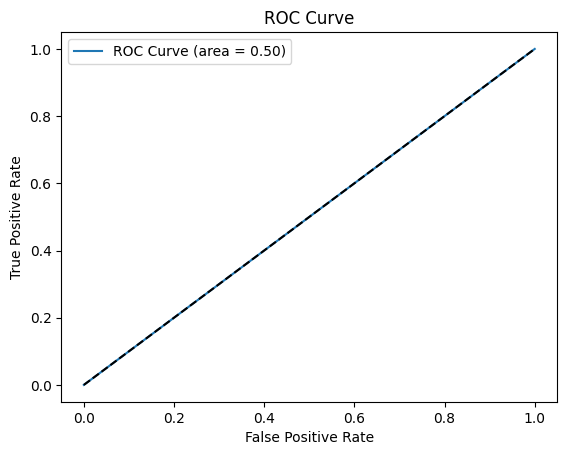

In [29]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Make predictions
y_pred = model.predict(X_test).round()
y_pred_proba = model.predict(X_test)

# Confusion Matrix
conf_mx = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_mx)

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=['No Heart Attack', 'Heart Attack'])
print("Classification Report:\n", class_report)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Plot ROC Curve
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


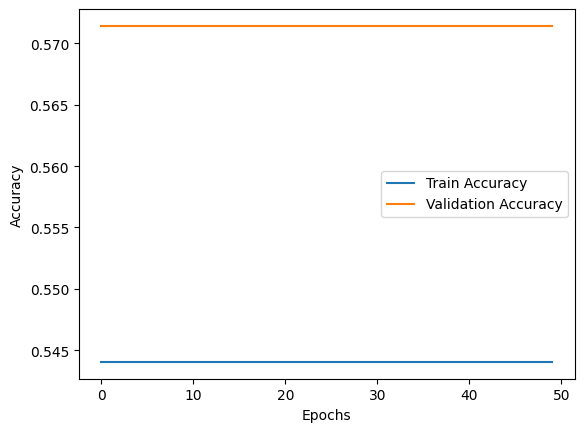

In [30]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()